In [ ]:
import os
import shutil
import zipfile
from google.colab import drive

# --- CONFIGURATION ---
ZIP_FILENAME = 'my_clean_cropped_data_splitted_and_resized.zip'  # The file in your Drive
DESTINATION_DIR = '/content/'

# 1. MOUNT DRIVE
print(">>> Step 1: Mounting Google Drive...")
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. COPY & UNZIP
source_path = f'/content/drive/MyDrive/{ZIP_FILENAME}'
local_zip_path = f'/content/{ZIP_FILENAME}'

print(f"\n>>> Step 2: Looking for {ZIP_FILENAME}...")

if not os.path.exists(source_path):
    print(f"ERROR: Could not find '{ZIP_FILENAME}' in My Drive.")
    print("Please make sure you added the shortcut to the root of 'My Drive'.")
else:
    print("File found. Copying to local runtime (for speed)...")
    shutil.copy(source_path, local_zip_path)

    print("Unzipping...")
    # Check if we need to clean up previous runs
    if os.path.exists('/content/my_clean_cropped_data_splitted_and_resized'):
        shutil.rmtree('/content/my_clean_cropped_data_splitted_and_resized')

    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        zip_ref.extractall(DESTINATION_DIR)
    print("Unzip complete.")

# 3. VERIFY & COUNT
print("\n>>> Step 3: Auditing Data Structure...")

base_dir = '/content/my_clean_cropped_data_splitted_and_resized'

if not os.path.exists(base_dir):
    print(f"CRITICAL ERROR: Expected folder '{base_dir}' not found.")
    print("Here is what was extracted instead:", os.listdir(DESTINATION_DIR))
else:
    print(f"Root folder found: {base_dir}")

    for split in ['train_balanced_aug','val', 'test']:
        split_path = os.path.join(base_dir, split)
        if not os.path.exists(split_path):
            print(f"  [WARNING] Missing '{split}' folder!")
            continue

        print(f"\n--- {split.upper()} SET ---")
        total_split = 0
        classes = sorted(os.listdir(split_path))

        for emotion in classes:
            emotion_path = os.path.join(split_path, emotion)
            if os.path.isdir(emotion_path):
                # Count only images
                count = len([f for f in os.listdir(emotion_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                print(f"    {emotion}: {count} images")
                total_split += count
        print(f"  Total {split} images: {total_split}")

print("\nData audit complete!")

>>> Step 1: Mounting Google Drive...
Mounted at /content/drive

>>> Step 2: Looking for my_clean_cropped_data_splitted_and_resized.zip...
File found. Copying to local runtime (for speed)...
Unzipping...
Unzip complete.

>>> Step 3: Auditing Data Structure...
Root folder found: /content/my_clean_cropped_data_splitted_and_resized

--- TRAIN_BALANCED_AUG SET ---
    angry: 200 images
    fear: 200 images
    happy: 200 images
    sad: 200 images
    surprised: 200 images
  Total train_balanced_aug images: 1000

--- VAL SET ---
    angry: 12 images
    fear: 23 images
    happy: 32 images
    sad: 20 images
    surprised: 8 images
  Total val images: 95

--- TEST SET ---
    angry: 12 images
    fear: 23 images
    happy: 32 images
    sad: 20 images
    surprised: 8 images
  Total test images: 95

Data audit complete!


In [ ]:
# EfficientNetB0 (simple) for your folder structure:
# /content/clean_cropped_data_splitted_and_resized/
#   train_balanced_aug/<class>/*.jpg
#   val/<class>/*.jpg
#   test/<class>/*.jpg

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,regularizers

# -----------------------------
# 0) Paths + basic params
# -----------------------------
BASE_DIR = "/content/my_clean_cropped_data_splitted_and_resized"
TRAIN_DIR = os.path.join(BASE_DIR, "train_balanced_aug")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# -----------------------------
# 1) Datasets (simple)
# -----------------------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)
print("Num classes:", num_classes)

# performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)



IMG_H, IMG_W = IMG_SIZE

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_H, IMG_W, 3)
)
base.trainable = False

inputs = keras.Input(shape=(IMG_H, IMG_W, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs)

x = base(x, training=False)
#x = cbam_block(x)
x = layers.GlobalAveragePooling2D()(x)

# simpler + regularized head

x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-3))(x)
x = layers.Dropout(0.35)(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.3, min_lr=1e-7),
]
class_weight = {
    0: .7,   # angry
    1: 3,   # fear
    2: 1.5,   # happy (often majority -> can downweight)
    3: 1,   # sad (HEAVY)
    4: 2.0,   # surprised (HEAVY)
}

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    class_weight=class_weight,
    callbacks=callbacks
)

from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np

def eval_on_test(model, test_ds, class_names):
    # 1) Get loss + accuracy from Keras
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)

    # 2) Get predictions for detailed metrics
    y_true, y_pred = [], []
    for x, y in test_ds:
        p = model.predict(x, verbose=0)
        y_true.extend(y.numpy())
        y_pred.extend(np.argmax(p, axis=1))

    f1 = f1_score(y_true, y_pred, average="weighted")

    print("\n====================")
    print(f"TEST LOSS: {test_loss:.4f}")
    print(f"TEST ACC : {test_acc*100:.2f}%")
    print(f"TEST F1  : {f1:.4f}")
    print("====================\n")
    print(classification_report(y_true, y_pred, target_names=class_names))


eval_on_test(model, test_ds, class_names)

model.trainable = True
for layer in base.layers[:-5]:
    layer.trainable = False


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

callbacks2 = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.3, min_lr=1e-6),
]


history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    class_weight=class_weight,
    callbacks=callbacks2
)
# -----------------------------
# 5) Test evaluation
# -----------------------------
eval_on_test(model, test_ds, class_names)



# Save model
model.save("/content/effnetb0_emotion.h5")
print("Saved: /content/effnetb0_emotion.h5")


Found 1000 files belonging to 5 classes.
Found 95 files belonging to 5 classes.
Found 95 files belonging to 5 classes.
Classes: ['angry', 'fear', 'happy', 'sad', 'surprised']
Num classes: 5
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 991ms/step - accuracy: 0.2960 - loss: 2.7531 - val_accuracy: 0.3158 - val_loss: 1.6804 - learning_rate: 1.0000e-04
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3913 - loss: 2.2225 - val_accuracy: 0.4000 - val_loss: 1.5267 - learning_rate: 1.0000e-04
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4936 - loss: 1.9383 - val_accuracy: 0.4632 - val_loss: 1.4237 - learning_rate: 1.0000e-04
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5575 - loss: 1.7830 - val_accuracy: 0.5474 - val_loss: 1.3311 - learning_rate: 1.0000e-04
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5901 - loss: 1.6971 - val_accuracy: 0.5789 - val_loss: 1.2750 - lea


TEST LOSS: 0.4740
TEST ACC : 92.63%
TEST F1  : 0.9254

              precision    recall  f1-score   support

       angry       1.00      0.75      0.86        12
        fear       0.85      1.00      0.92        23
       happy       0.97      0.97      0.97        32
         sad       0.90      0.90      0.90        20
   surprised       1.00      0.88      0.93         8

    accuracy                           0.93        95
   macro avg       0.94      0.90      0.92        95
weighted avg       0.93      0.93      0.93        95

Saved: /content/effnetb0_emotion.h5


In [ ]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# -------- CBAM blocks (Keras-safe) --------
def channel_attention(x, ratio=8):
    c = x.shape[-1]
    avg_pool = layers.GlobalAveragePooling2D()(x)
    max_pool = layers.GlobalMaxPooling2D()(x)

    shared_1 = layers.Dense(c // ratio, activation="relu")
    shared_2 = layers.Dense(c)

    avg_out = shared_2(shared_1(avg_pool))
    max_out = shared_2(shared_1(max_pool))

    scale = layers.Activation("sigmoid")(avg_out + max_out)
    scale = layers.Reshape((1, 1, c))(scale)
    return layers.Multiply()([x, scale])

def spatial_attention(x, kernel_size=7):
    # Use Lambda layers instead of tf.reduce_* directly
    avg_pool = layers.Lambda(lambda t: tf.reduce_mean(t, axis=-1, keepdims=True))(x)
    max_pool = layers.Lambda(lambda t: tf.reduce_max(t, axis=-1, keepdims=True))(x)

    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    scale = layers.Conv2D(1, kernel_size=kernel_size, padding="same", activation="sigmoid")(concat)
    return layers.Multiply()([x, scale])

def cbam_block(x, ratio=8, kernel_size=7):
    x = channel_attention(x, ratio=ratio)
    x = spatial_attention(x, kernel_size=kernel_size)
    return x


In [ ]:
# EfficientNetB0 (simple) for your folder structure:
# /content/clean_cropped_data_splitted_and_resized/
#   train_balanced_aug/<class>/*.jpg
#   val/<class>/*.jpg
#   test/<class>/*.jpg

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,regularizers

# -----------------------------
# 0) Paths + basic params
# -----------------------------
BASE_DIR = "/content/my_clean_cropped_data_splitted_and_resized"
TRAIN_DIR = os.path.join(BASE_DIR, "train_balanced_aug")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# -----------------------------
# 1) Datasets (simple)
# -----------------------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)
print("Num classes:", num_classes)

# performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)



IMG_H, IMG_W = IMG_SIZE

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_H, IMG_W, 3)
)
base.trainable = False

inputs = keras.Input(shape=(IMG_H, IMG_W, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs)

x = base(x, training=False)
x = cbam_block(x)
x = layers.GlobalAveragePooling2D()(x)

# simpler + regularized head

x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-3))(x)
x = layers.Dropout(0.35)(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.3, min_lr=1e-7),
]
class_weight = {
    0: .7,   # angry
    1: 3,   # fear
    2: 1.5,   # happy (often majority -> can downweight)
    3: 1,   # sad (HEAVY)
    4: 2.0,   # surprised (HEAVY)
}

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    class_weight=class_weight,
    callbacks=callbacks
)

from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np

def eval_on_test(model, test_ds, class_names):
    # 1) Get loss + accuracy from Keras
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)

    # 2) Get predictions for detailed metrics
    y_true, y_pred = [], []
    for x, y in test_ds:
        p = model.predict(x, verbose=0)
        y_true.extend(y.numpy())
        y_pred.extend(np.argmax(p, axis=1))

    f1 = f1_score(y_true, y_pred, average="weighted")

    print("\n====================")
    print(f"TEST LOSS: {test_loss:.4f}")
    print(f"TEST ACC : {test_acc*100:.2f}%")
    print(f"TEST F1  : {f1:.4f}")
    print("====================\n")
    print(classification_report(y_true, y_pred, target_names=class_names))


eval_on_test(model, test_ds, class_names)

model.trainable = True
for layer in base.layers[:-5]:
    layer.trainable = False


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

callbacks2 = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.3, min_lr=1e-6),
]


history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    class_weight=class_weight,
    callbacks=callbacks2
)
# -----------------------------
# 5) Test evaluation
# -----------------------------
eval_on_test(model, test_ds, class_names)



# Save model
model.save("/content/effnetb0_emotion.h5")
print("Saved: /content/effnetb0_emotion.h5")


Found 1000 files belonging to 5 classes.
Found 95 files belonging to 5 classes.
Found 95 files belonging to 5 classes.
Classes: ['angry', 'fear', 'happy', 'sad', 'surprised']
Num classes: 5
Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 800ms/step - accuracy: 0.2312 - loss: 2.8651 - val_accuracy: 0.2737 - val_loss: 1.8141 - learning_rate: 1.0000e-04
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3047 - loss: 2.6794 - val_accuracy: 0.2737 - val_loss: 1.7515 - learning_rate: 1.0000e-04
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3491 - loss: 2.4138 - val_accuracy: 0.3263 - val_loss: 1.6458 - learning_rate: 1.0000e-04
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4173 - loss: 2.0936 - val_accuracy: 0.4947 - val_loss: 1.4835 - learning_rate: 1.0000e-04
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4910 - loss: 1.8441 - val_accuracy: 0.5263 - val_loss: 1.3499 - learning_rate: 1.0000e-04
Epoch 6/200
32/32 ━━━━━━━━━━


TEST LOSS: 0.4274
TEST ACC : 95.79%
TEST F1  : 0.9579

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        12
        fear       0.91      0.91      0.91        23
       happy       0.97      0.97      0.97        32
         sad       1.00      1.00      1.00        20
   surprised       0.88      0.88      0.88         8

    accuracy                           0.96        95
   macro avg       0.95      0.95      0.95        95
weighted avg       0.96      0.96      0.96        95

Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 804ms/step - accuracy: 1.0000 - loss: 0.2050 - val_accuracy: 0.8842 - val_loss: 0.5391 - learning_rate: 1.0000e-05
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9981 - loss: 0.2053 - val_accuracy: 0.8842 - val_loss: 0.5483 - learning_rate: 1.0000e-05
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9996 - loss: 0.2028 - val_accuracy: 0.8842 - val_loss: 0.5360 - learning_rate:


TEST LOSS: 0.4172
TEST ACC : 95.79%
TEST F1  : 0.9579

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        12
        fear       0.91      0.91      0.91        23
       happy       0.97      0.97      0.97        32
         sad       1.00      1.00      1.00        20
   surprised       0.88      0.88      0.88         8

    accuracy                           0.96        95
   macro avg       0.95      0.95      0.95        95
weighted avg       0.96      0.96      0.96        95

Saved: /content/effnetb0_emotion.h5


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class CoordinateAttention(layers.Layer):
    def __init__(self, reduction=32, **kwargs):
        super().__init__(**kwargs)
        self.reduction = reduction

    def build(self, input_shape):
        c = int(input_shape[-1])
        mip = max(8, c // self.reduction)

        self.conv1 = layers.Conv2D(mip, 1, padding="same", use_bias=False)
        self.bn1   = layers.BatchNormalization()
        self.act   = layers.Activation("swish")

        self.conv_h = layers.Conv2D(c, 1, padding="same", use_bias=False)
        self.conv_w = layers.Conv2D(c, 1, padding="same", use_bias=False)
        super().build(input_shape)

    def call(self, x, training=None):
        # x: (B,H,W,C)
        x_h = tf.reduce_mean(x, axis=2, keepdims=True)        # (B,H,1,C)
        x_w = tf.reduce_mean(x, axis=1, keepdims=True)        # (B,1,W,C)
        x_w = tf.transpose(x_w, [0, 2, 1, 3])                 # (B,W,1,C)

        y = tf.concat([x_h, x_w], axis=1)                     # (B,H+W,1,C)
        y = self.conv1(y)
        y = self.bn1(y, training=training)
        y = self.act(y)

        h = tf.shape(x_h)[1]
        y_h, y_w = tf.split(y, [h, tf.shape(y)[1] - h], axis=1)
        y_w = tf.transpose(y_w, [0, 2, 1, 3])                 # (B,1,W,mip)

        a_h = tf.keras.activations.sigmoid(self.conv_h(y_h))  # (B,H,1,C)
        a_w = tf.keras.activations.sigmoid(self.conv_w(y_w))  # (B,1,W,C)

        return x * a_h * a_w


In [ ]:
# EfficientNetB0 (simple) for your folder structure:
# /content/clean_cropped_data_splitted_and_resized/
#   train_balanced_aug/<class>/*.jpg
#   val/<class>/*.jpg
#   test/<class>/*.jpg

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,regularizers

# -----------------------------
# 0) Paths + basic params
# -----------------------------
BASE_DIR = "/content/my_clean_cropped_data_splitted_and_resized"
TRAIN_DIR = os.path.join(BASE_DIR, "train_balanced_aug")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# -----------------------------
# 1) Datasets (simple)
# -----------------------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)
print("Num classes:", num_classes)

# performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)



IMG_H, IMG_W = IMG_SIZE

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_H, IMG_W, 3)
)
base.trainable = False

inputs = keras.Input(shape=(IMG_H, IMG_W, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs)

x = base(x, training=False)
x = CoordinateAttention()(x)
x = layers.GlobalAveragePooling2D()(x)

# simpler + regularized head

x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-3))(x)
x = layers.Dropout(0.35)(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.3, min_lr=1e-7),
]
class_weight = {
    0: .7,   # angry
    1: 3,   # fear
    2: 1.5,   # happy (often majority -> can downweight)
    3: 1,   # sad (HEAVY)
    4: 2.0,   # surprised (HEAVY)
}

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    class_weight=class_weight,
    callbacks=callbacks
)

from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np

def eval_on_test(model, test_ds, class_names):
    # 1) Get loss + accuracy from Keras
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)

    # 2) Get predictions for detailed metrics
    y_true, y_pred = [], []
    for x, y in test_ds:
        p = model.predict(x, verbose=0)
        y_true.extend(y.numpy())
        y_pred.extend(np.argmax(p, axis=1))

    f1 = f1_score(y_true, y_pred, average="weighted")

    print("\n====================")
    print(f"TEST LOSS: {test_loss:.4f}")
    print(f"TEST ACC : {test_acc*100:.2f}%")
    print(f"TEST F1  : {f1:.4f}")
    print("====================\n")
    print(classification_report(y_true, y_pred, target_names=class_names))


eval_on_test(model, test_ds, class_names)

model.trainable = True
for layer in base.layers[:-5]:
    layer.trainable = False


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

callbacks2 = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.3, min_lr=1e-6),
]


history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    class_weight=class_weight,
    callbacks=callbacks2
)
# -----------------------------
# 5) Test evaluation
# -----------------------------
eval_on_test(model, test_ds, class_names)



# Save model
model.save("/content/effnetb0_emotion.h5")
print("Saved: /content/effnetb0_emotion.h5")


Found 1000 files belonging to 5 classes.
Found 95 files belonging to 5 classes.
Found 95 files belonging to 5 classes.
Classes: ['angry', 'fear', 'happy', 'sad', 'surprised']
Num classes: 5
Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.2420 - loss: 2.8697 - val_accuracy: 0.2737 - val_loss: 1.7510 - learning_rate: 1.0000e-04
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.3368 - loss: 2.6172 - val_accuracy: 0.2842 - val_loss: 1.6908 - learning_rate: 1.0000e-04
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3693 - loss: 2.4133 - val_accuracy: 0.3158 - val_loss: 1.6229 - learning_rate: 1.0000e-04
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3941 - loss: 2.2220 - val_accuracy: 0.3368 - val_loss: 1.5556 - learning_rate: 1.0000e-04
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4096 - loss: 2.0905 - val_accuracy: 0.3684 - val_loss: 1.4989 - learning_rate: 1.0000e-04
Epoch 6/200
32/32 ━━━━━━━━━━━━


TEST LOSS: 0.2479
TEST ACC : 95.79%
TEST F1  : 0.9582

              precision    recall  f1-score   support

       angry       1.00      0.92      0.96        12
        fear       0.88      1.00      0.94        23
       happy       1.00      0.97      0.98        32
         sad       0.95      0.95      0.95        20
   surprised       1.00      0.88      0.93         8

    accuracy                           0.96        95
   macro avg       0.97      0.94      0.95        95
weighted avg       0.96      0.96      0.96        95

Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 51s 863ms/step - accuracy: 1.0000 - loss: 0.0822 - val_accuracy: 0.9368 - val_loss: 0.2906 - learning_rate: 1.0000e-05
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 1.0000 - loss: 0.0793 - val_accuracy: 0.9368 - val_loss: 0.2900 - learning_rate: 1.0000e-05
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 1.0000 - loss: 0.0788 - val_accuracy: 0.9368 - val_loss: 0.2892 - learning_rate:


TEST LOSS: 0.2423
TEST ACC : 94.74%
TEST F1  : 0.9478

              precision    recall  f1-score   support

       angry       1.00      0.92      0.96        12
        fear       0.88      1.00      0.94        23
       happy       1.00      0.94      0.97        32
         sad       0.90      0.95      0.93        20
   surprised       1.00      0.88      0.93         8

    accuracy                           0.95        95
   macro avg       0.96      0.94      0.94        95
weighted avg       0.95      0.95      0.95        95

Saved: /content/effnetb0_emotion.h5


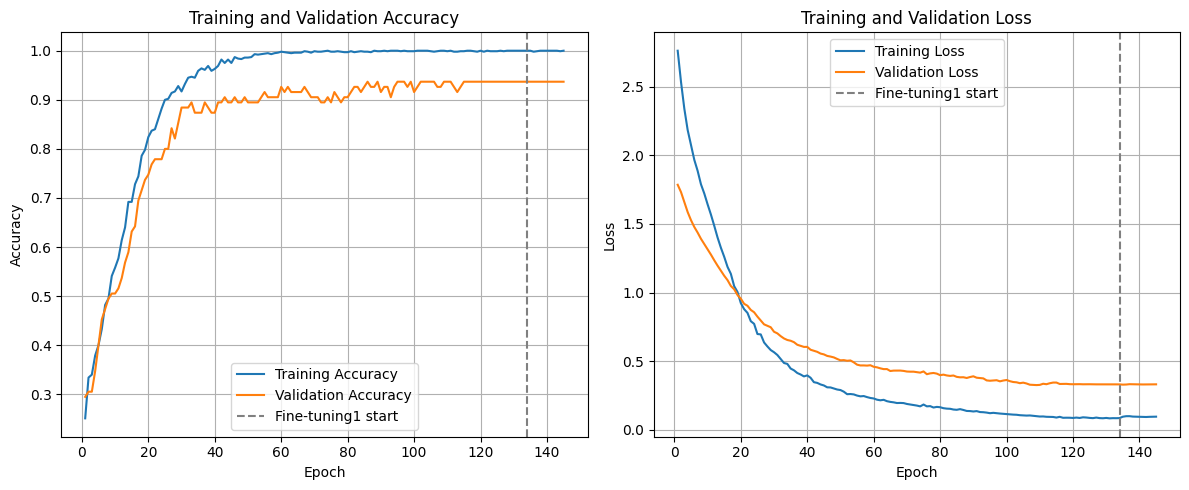

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



y_true, y_pred = [], []
for x, y in test_ds:
    p = model.predict(x, verbose=0)
    y_true.extend(y.numpy())
    y_pred.extend(np.argmax(p, axis=1))


acc = history.history['accuracy']+history2.history['accuracy']
val_acc = history.history['val_accuracy']+history2.history['val_accuracy']
loss = history.history['loss']+history2.history['loss']
val_loss = history.history['val_loss']+history2.history['val_loss']

epochs = range(1, len(acc) + 1)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.axvline(x=len(history.history['accuracy']),
            color='gray', linestyle='--', label='Fine-tuning1 start')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.axvline(x=len(history.history['loss']),
            color='gray', linestyle='--', label='Fine-tuning1 start')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



--- Generating Confusion Matrix ---


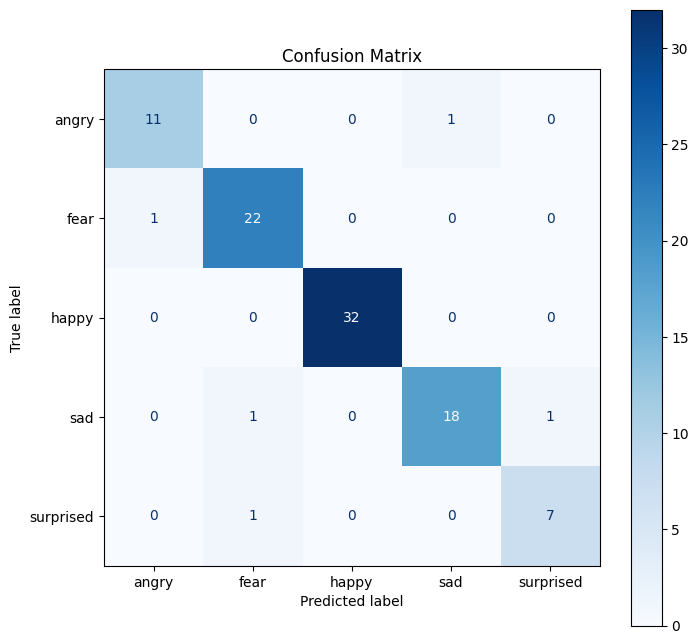

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []
for x, y in test_ds:
    p = model.predict(x, verbose=0)
    y_true.extend(y.numpy())
    y_pred.extend(np.argmax(p, axis=1))
print("\n--- Generating Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix')
plt.show()